# AGH 
## Teoria Współbieżności
### Studia niestacjonarne, semestr 6.
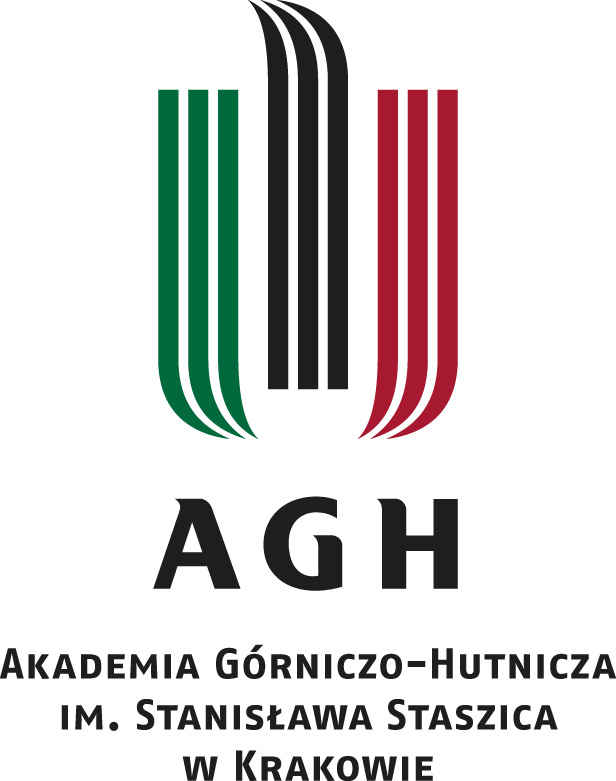

### Laboratorium 5: Przetwarzanie potokowe z buforem


#### Mateusz Popielarz



# Część teoretyczna

## Czym jest przetwarzanie potokowe?

Przetwarzanie potokowe składa się z łańcucha elementów przetwarzających - mogą to być procesy, wątki, funkcje - połączonych ze sobą tak, że wynik poprzedniego jest wejściem kolejnego. Dane płynące w takim potoku tworzą strumień (ang. stream).
Przetwarzanie potokowe jest także paragdymatem programowania przepływu danych - dzięki niemu możemy łatwiej zamodelować ograniczoną formę współbierzności bez synchronizacji stanu pomiędzy wątkami (potokami).


# Zadania


Do pomocy w rozwiązaniu zadań stworzyliśmy kilka dodatkowych pomocniczych funkcji. 
Poniższa funkcja odpowiada za łączenie wykresów w jeden

In [3]:
import java.awt.image.BufferedImage;
import java.util.stream.Stream;

public BufferedImage Combine(BufferedImage... images)
{
    var space = 10;
    var h = Stream.of(images).mapToInt(i->i.getHeight()).max().orElseThrow(NoSuchElementException::new);
    var w =  Stream.of(images).mapToInt(i -> i.getWidth() + space).sum();
    var result =new BufferedImage(w, h, BufferedImage.TYPE_INT_ARGB);
    var  g = result.getGraphics();
    int currentWidth = 0;
    for(var img : images){
        g.drawImage(img, currentWidth,0, null);
        currentWidth = currentWidth +space + img.getWidth();
    }
    g.dispose();
    return result;
}

## Zadanie 1.

![Zadanie](D:\notebooks\image.png)

In [121]:
import java.util.concurrent.locks.*;
import java.util.ArrayList;
import java.util.List;

void writeLine(String text) {
    //System.out.println(text);
}

abstract class Processor extends Thread {
    protected int index = 0;
    protected final Lock lock = new ReentrantLock();
    protected final Condition indexChanged = lock.newCondition();
    protected Boolean finished = false;
    public long waitTime;
    protected Processor ancestor = null;
    protected long[] buffer;


    public Processor(long[] buf, Processor asc) {
        this.buffer = buf;
        this.ancestor = asc;
    }

    public void run() {
        while (!this.finished) {
            this.ancestor.lock.lock();
            try {
                while (this.index == this.ancestor.index && this.ancestor.finished == false) {
                    try {
                        this.ancestor.indexChanged.await();
                    } catch (InterruptedException e) {
                        writeLine("Interrupt");
                    }
                }
                
                this.lock.lock();
                try {
                    if (this.ancestor.finished && this.index == this.ancestor.index) {
                        this.finished = true;
                    } else {
                        long i = this.buffer[this.index];
                        long result = this.costam(i);
                        this.buffer[this.index] = result;
                        this.index++;
                    }

                    this.indexChanged.signal();
                } finally {
                    this.lock.unlock();
                }

            } finally {
                this.ancestor.lock.unlock();
            }
        }
    }

    protected long costam(long i) {
        return 0;
    }
}

class Producer extends Processor {
    private long count;

    public Producer(long count, long[] buf, Processor asc) {
        super(buf, asc);
        this.count = count;
    }

    public void run() {
        this.lock.lock();
        try {
            for (long i = 0; i < this.count; i++) {
                this.buffer[this.index] = 1;
                this.index++;
                writeLine("producer: " + 1);
                this.indexChanged.signal();
            }
            this.finished = true;
        } finally {
            lock.unlock();
        }
    }
}

class Consumer extends Processor {

    public Consumer(long[] buf, Processor asc) {
        super(buf, asc);
    }

    protected long costam(long i) {
        writeLine("Consumer:  " + i);
        return -1;
    }
}

class Converter extends Processor {
    private int id;
    public Converter(long[] buf, Processor asc, int id) {
        super(buf, asc);
        this.id = id;
    }

    protected long costam(long i) {
        var r = i * 10 + 1;
        try{
           sleep(1);
           }
        catch(InterruptedException e){
           writeLine(e.getMessage());
        }
        writeLine("Converter " + id + " : " + r);
        return r;
    }
}

public long Start(int toProduce, int n, int chain) {
    long start = System.currentTimeMillis();
    long[] buffor = new long[n];
    Producer prod = new Producer(toProduce, buffor, null);
    List<Processor> list = new ArrayList<Processor>(chain);
    list.add(prod);
    for (int i = 0; i < chain; i++) {
        var last = list.get(list.size() - 1);
        list.add(new Converter(buffor, last, i));
    }
    Consumer cons = new Consumer(buffor, list.get(list.size() - 1));
    list.add(cons);

    for (Processor l : list) {
        l.start();
    }

    for (Processor l : list) {
        try {
            l.join();
        } catch (InterruptedException ex) {
            writeLine("Exception has been caught" + ex);
        }
    }
    long time = System.currentTimeMillis() - start;
    writeLine("czas: " + time);
    return time;
}

#### Przykładowy wynik działania

In [130]:
void writeLine(String text) {     System.out.println(text); }
Start(6,6,6);
void writeLine(String text) {  }

producer: 1
producer: 1
producer: 1
producer: 1
producer: 1
producer: 1
Converter 0 : 11
Converter 0 : 11
Converter 0 : 11
Converter 0 : 11
Converter 0 : 11
Converter 1 : 111
Converter 1 : 111
Converter 2 : 1111
Converter 0 : 11
Converter 2 : 1111
Converter 1 : 111
Converter 3 : 11111
Converter 1 : 111
Converter 3 : 11111
Converter 4 : 111111
Converter 1 : 111
Converter 1 : 111
Converter 4 : 111111
Converter 2 : 1111
Converter 5 : 1111111
Converter 2 : 1111
Converter 5 : 1111111
Consumer:  1111111
Converter 2 : 1111
Consumer:  1111111
Converter 2 : 1111
Converter 3 : 11111
Converter 3 : 11111
Converter 3 : 11111
Converter 3 : 11111
Converter 4 : 111111
Converter 4 : 111111
Converter 4 : 111111
Converter 4 : 111111
Converter 5 : 1111111
Converter 5 : 1111111
Consumer:  1111111
Consumer:  1111111
Converter 5 : 1111111
Converter 5 : 1111111
Consumer:  1111111
Consumer:  1111111
czas: 55


### Wyniki parametryzowane ilością producentów, czas = f(konwertery)
Wykres przedstawiający wzrost czasu wykonania w stosunku od producentów, gdy zmienną `x` jest ilość konwerterów.

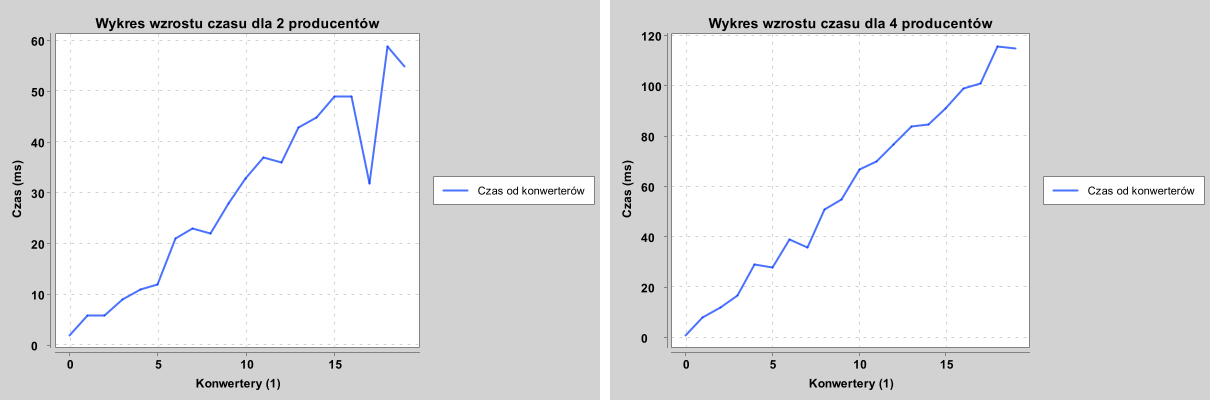

In [124]:
%maven org.knowm.xchart:xchart:3.5.2
import org.knowm.xchart.*;
import java.util.stream.DoubleStream; 

var samples = 20;
var jump = 1;

var x = new double[samples];
var y = new double[samples];


public BufferedImage PerProducents(int producents)
{
    for(int l = 0; l < samples; l += jump)
    {
        x[l] = l;
        y[l] = Start(producents, producents, l);
    }

    XYChart c = QuickChart.getChart("Wykres wzrostu czasu dla " + producents + " producentów", "Konwertery (1)", "Czas (ms)", "Czas od konwerterów", x, y);
    return BitmapEncoder.getBufferedImage(c);
}

var warmup = PerProducents(1);
Combine(
        PerProducents(2),
        PerProducents(4)
    );

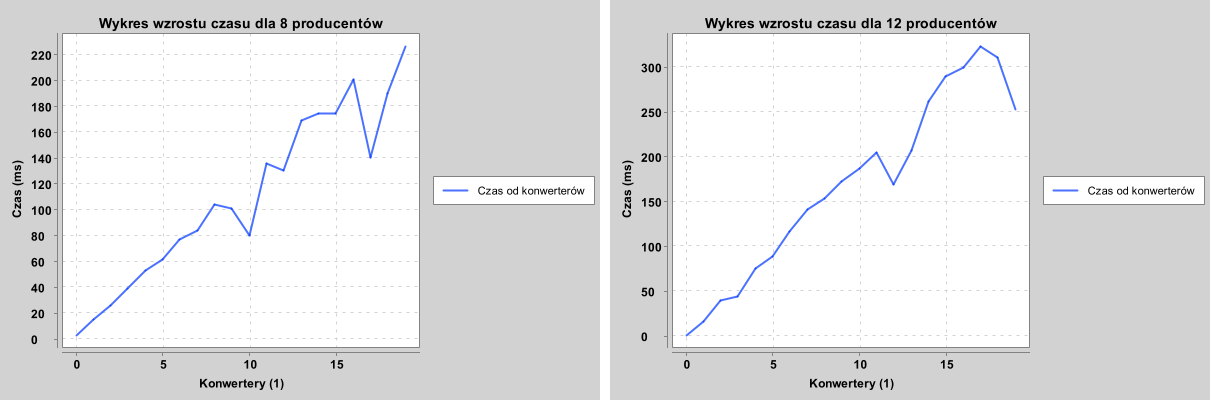

In [125]:
var warmup = PerProducents(1);
Combine(
        PerProducents(8),
        PerProducents(12)
    );

#### Wnioski

Możemy zauważyć, że wzrost czasu, gdy zmienną jest liczba konwerterów jest liniowy. Oznacza to, że aplikacje mogą być łatwo skalowalne poprzez dołożenie kolejnej warstwy przetwarzania, widzimy, że dla 8 i 12 są duże skoki - spowodowane jest to tym, że aplikacja jest uruchamiana na komputerze z 4 rdzeniami fizycznymi i 8 logicznymi, wątki muszę walczyć o czas cpu. 

### Wyniki parametryzowane ilością konwerterów, czas = f(producent)
Wykres przedstawiający wzrost czasu wykonania w stosunku od konwerterów, gdy zmienną `x` jest ilość producentów.

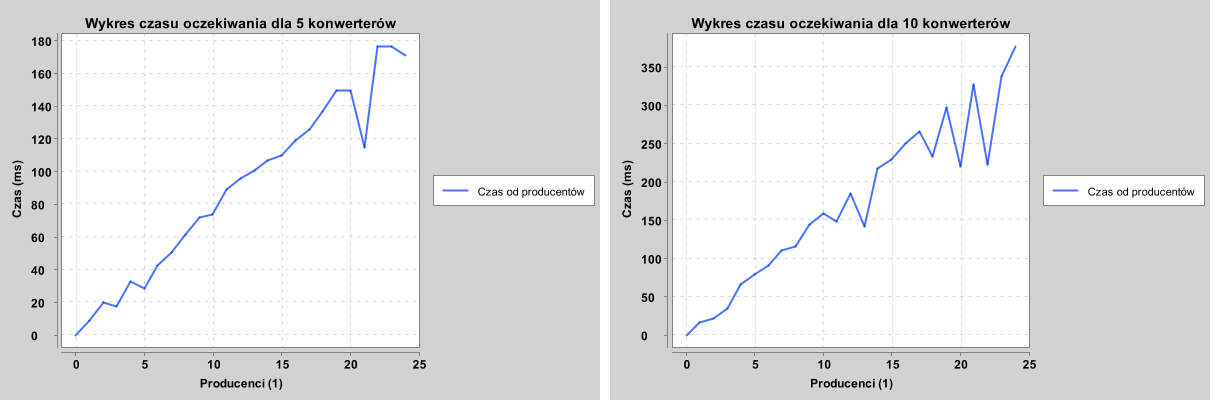

In [126]:
%maven org.knowm.xchart:xchart:3.5.2

import org.knowm.xchart.*;
import java.awt.image.BufferedImage;
samples = 25;
var x = new double[samples];
var y = new double[samples];


public BufferedImage PerConverter(int converters)
{
    for(int l = 1; l < samples; l++)
    {
        x[l] = l;
        y[l] = Start(l, l, converters);
    }

    XYChart c = QuickChart.getChart("Wykres czasu oczekiwania dla " + converters + " konwerterów" , "Producenci (1)", "Czas (ms)", "Czas od producentów", x, y);
    return BitmapEncoder.getBufferedImage(c);
}

var warmup =         PerConverter(5);
Combine(PerConverter(5), PerConverter(10))
     

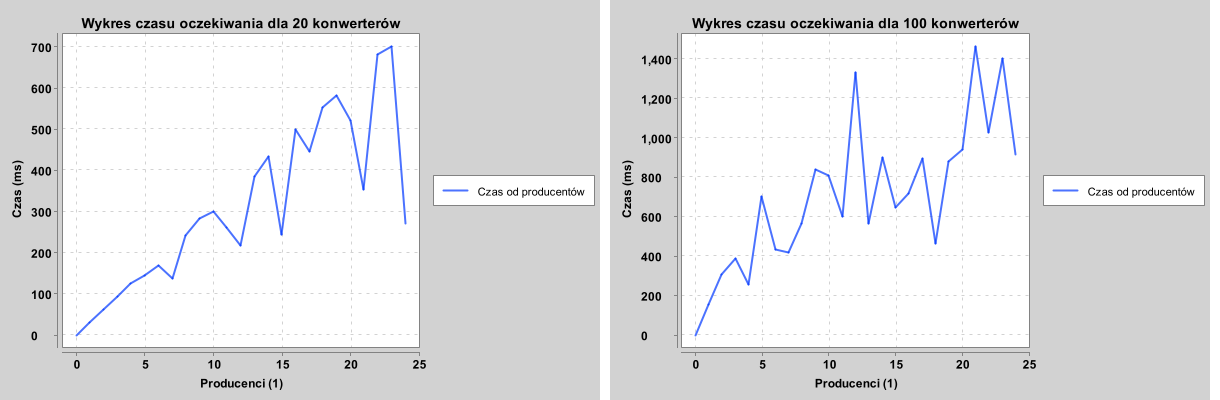

In [128]:
Combine(PerConverter(20), PerConverter(100));

#### Wnioski
Widzimy tutaj, szczególnie wykres od 10 konwerterów wzwyż, że, gdy liczba producentów zbliża się do 8 wyniki zaczynają być bardziej niestabilne. Wiąże się to z wcześniej wymienioną walką o zasoby. Najepsze efekty uzyskamy, gdy liczba równolegle mogących pracować bytów jest zbliżona do ilości rdzeni logicznych - wtedy uzyskujemy optymalną wydajność.


### Zadanie 2

![Zadanie 2](D:\notebooks\image2.png)


In [97]:
import java.util.concurrent.locks.*;
import java.util.concurrent.atomic.*;
import java.util.Random;

void writeLine(String text) {     System.out.println(text); }

public class Buffer2 {
    final Lock lock = new ReentrantLock();
    final Condition notEmpty = lock.newCondition();
    final Condition notFull  = lock.newCondition();

    public Buffer2(int length){
        this.items = new int[length];
    }

    int[] items ;
    int putIndex = 0;
    int getIndex = 0;
    int length = 0;

    public long put(int el, int count) {
        long result = 0;
        lock.lock();
        try {
            long start = System.nanoTime();
            while (length >= (items.length - count)){
                try {
                    notFull.await();
                }
                catch(InterruptedException ie){
                    // Suspicious Wakeup
                }
            }
            result = System.nanoTime() - start;
            writeLine("put size: " + count + " time " + result);

            for(var i = 0; i < count; i++){
                items[putIndex] = el;
                if (++putIndex == items.length) {
                    putIndex = 0;
                }
                ++length;
            }
            notEmpty.signalAll();
        }
        finally {
            lock.unlock();
        }
        return result;
    }

    public long get(int count)  {
        long result = 0;
        lock.lock();
        try {
            long start = System.nanoTime();
            while (count > length){
                try {
                    notFull.awaitNanos(100);
                }
                catch(InterruptedException ie){
                    //
                }
            }
            result = System.nanoTime() - start;
            writeLine("get size: " + count + " time " + result);
            var res = new ArrayList<Integer>();
            for(var i = 0; i < count; i++){
                int x = items[getIndex];
                if (++getIndex == items.length) {
                    getIndex = 0;
                }
                res.add(x);
                --length;
            }
            notFull.signalAll();
            return result;
        }
        finally {
            lock.unlock();
        }
    }
}

public class Producer2 extends Thread {
    private Random rand;
    private Buffer2 buffer;
    private AtomicInteger elements;
    private int limit; 
    
    public ArrayList<Integer> packetSizes = new ArrayList<Integer>();
    public ArrayList<Long> waitTimes = new ArrayList<Long>();

    public Producer2(Random rand, Buffer2 buffer, AtomicInteger elements, int limit){
        this.rand = rand;
        this.buffer = buffer;
        this.elements = elements;
        this.limit = limit;
    }
    public void run() {
        var next = this.rand.nextInt(this.limit) + 1;
        packetSizes.add(next);
        var time = this.buffer.put(1, next);
        waitTimes.add(time);
    }
}

public class Consumer2 extends Thread {
    private Random rand;
    private Buffer2 buffer;
    private AtomicInteger elements;
    private int limit; 

    public ArrayList<Integer> packetSizes = new ArrayList<Integer>();
    public ArrayList<Long> waitTimes = new ArrayList<Long>();

    public Consumer2(Random rand, Buffer2 buffer, AtomicInteger elements, int limit){
        this.rand = rand;
        this.buffer = buffer;
        this.elements = elements;
        this.limit = limit;
    }
    
    public void run() {
        var next = this.rand.nextInt(this.limit) + 1;
        packetSizes.add(next);
        var time = this.buffer.get(next);
        waitTimes.add(time);
    }
}



#### Działanie

W powyższym algorytmie producenci będą produkować losową wartość z zakresu <1, M>, gdzie wielkość buforu to 2M.

W celu zagwarantowania ilości pobrań/włożeń do bufora używam techniki compareAndSwap w celu zachowania tego algorytmu lock/free.

Poniżej kod rysujący wykres i przykładowy output



In [98]:
%maven org.knowm.xchart:xchart:3.5.2

import org.knowm.xchart.*;
import java.awt.image.BufferedImage;

 private List<Double> gausianAvg(List<Integer> xData, double mean, double std) {

    List<Double> yData = new ArrayList<Double>(xData.size());

    for (int i = 0; i < xData.size(); i++) {
      yData.add((1 / (std * Math.sqrt(2 * Math.PI))) * Math.exp(-(((xData.get(i) - mean) * (xData.get(i) - mean)) / ((2 * std * std)))));
    }
    return yData;
  }

public Object Compute2(int pk, int m, int retries) throws InterruptedException
{
    var sizeToTimesP = new HashMap<Integer, Integer>();
    var sizeToDurationP = new HashMap<Integer, Long>();

    var sizeToTimesK = new HashMap<Integer, Integer>();
    var sizeToDurationK = new HashMap<Integer, Long>();

    var l = 0;
    var xp = new ArrayList<Number>();
    var yp = new ArrayList<Number>();

    var xK = new ArrayList<Number>();
    var yK = new ArrayList<Number>();

    var limit = m;
    var seed = new Random().nextInt();
    var allToProduce = new AtomicInteger(limit);
    var allToConsume = new AtomicInteger(limit);
    var random1 = new Random(seed);
    var random2 = new Random(seed);

    var ps = new ArrayList<Producer2>();
    var cs = new ArrayList<Consumer2>();
    var b = new Buffer2(m * 2);
    
    for(var i = 0; i < pk; i++){ ps.add(new Producer2(random1, b, allToProduce, limit)); }
    for(var i = 0; i < pk; i++){ cs.add(new Consumer2(random2, b, allToConsume, limit)); }
    for(var p : ps){ p.start();}
    for(var c : cs){ c.start();}
    for(var p : ps)
    {
        p.join();
        for(int q = 0; q < p.packetSizes.size(); q++)
        {
            var size = p.packetSizes.get(q);
            var sizeTimes = sizeToTimesP.getOrDefault(size, 0);
            sizeToTimesP.put(size, sizeTimes + 1);
            var time = p.waitTimes.get(q);
            var sizeDuration = sizeToDurationP.getOrDefault(size, 0l);
            sizeToDurationP.put(size, sizeDuration + time);
        }
    }
    
    for(var p : cs){ p.join();
     for(int q = 0; q < p.packetSizes.size(); q++)
        {
            var size = p.packetSizes.get(q);
            var sizeTimes = sizeToTimesK.getOrDefault(size, 0);
            sizeToTimesK.put(size, sizeTimes + 1);
            var time = p.waitTimes.get(q);
            var sizeDuration = sizeToDurationK.getOrDefault(size, 0l);
            sizeToDurationK.put(size, sizeDuration + time);
        }
    }
    
    
    var byKeyP = new ArrayList<>(sizeToTimesP.keySet());
    Collections.sort(byKeyP);
    for (var entry : byKeyP) {
        var size = entry;
        var times = sizeToTimesP.get(size);
        var aggDur = sizeToDurationP.get(size);
        xp.add(size);
        yp.add(aggDur / times);
    }
    
    var byKeyK = new ArrayList<>(sizeToTimesK.keySet());
    Collections.sort(byKeyK);
    for (var entry : byKeyK) {
        var size = entry;
        var times = sizeToTimesK.get(size);
        var aggDur = sizeToDurationK.get(size);
        xK.add(size);
        yK.add(aggDur / times);
    }

    XYChart cP = QuickChart.getChart("Wykres czasu oczekiwania dla P/K = " + pk + ", M = " + m , "Rozmiar procji (1)", "Czas oczekiwania na dostęp (ns)", "Czas oczekiwania producenta", xp, yp);
    cP.getStyler().setDefaultSeriesRenderStyle(XYSeries.XYSeriesRenderStyle.Line);
    
    XYChart cK = QuickChart.getChart("Wykres czasu oczekiwania dla P/K = " + pk + ", M = " + m, "Rozmiar procji (1)", "Czas oczekiwania na dostęp (ns)", "Czas oczekiwania konsumenta", xK, yK);
    cK.getStyler().setDefaultSeriesRenderStyle(XYSeries.XYSeriesRenderStyle.Line);
    
    return Combine( BitmapEncoder.getBufferedImage(cP),  BitmapEncoder.getBufferedImage(cK));
}
public void writeLine(String s) {}



#### Wykresy zależności

Dla M == 1000

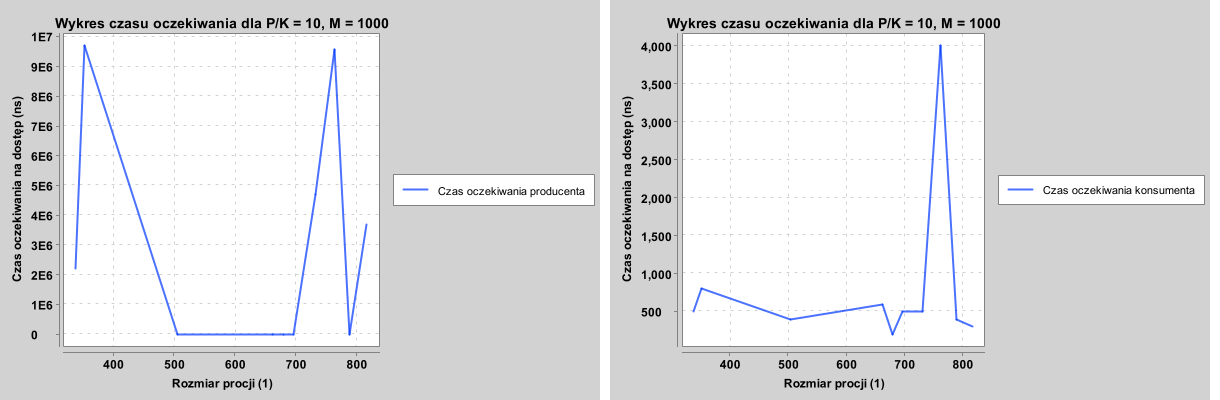

In [100]:
Compute2(10, 1000, 1);

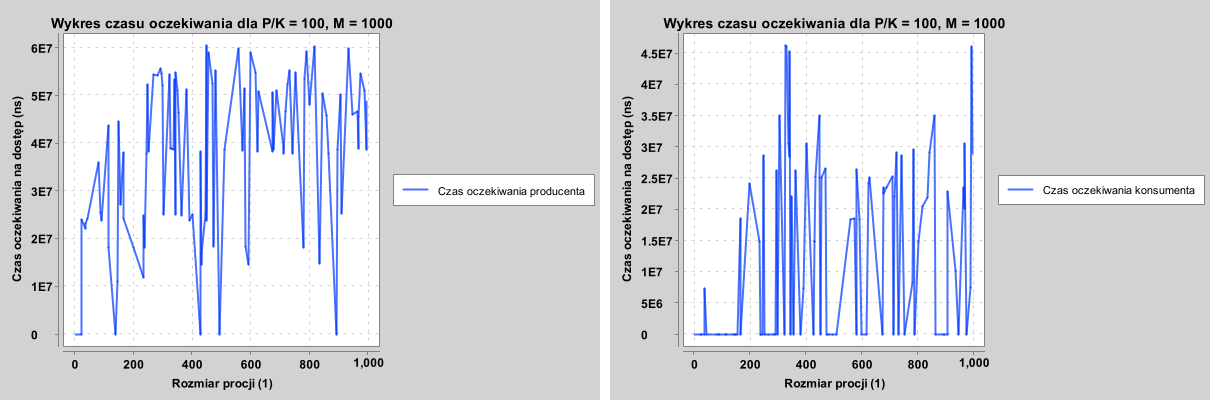

In [101]:
Compute2(100, 1000, 1);

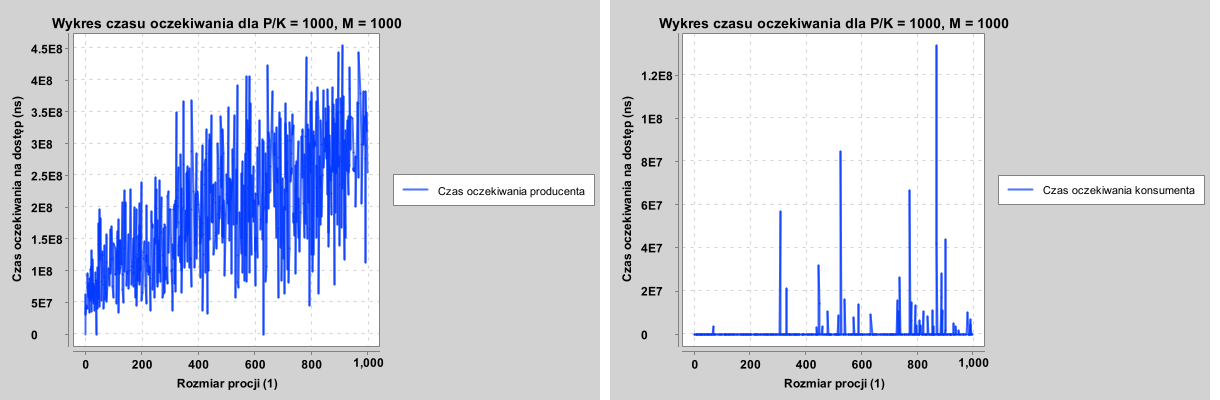

In [102]:
Compute2(1000, 1000, 1);

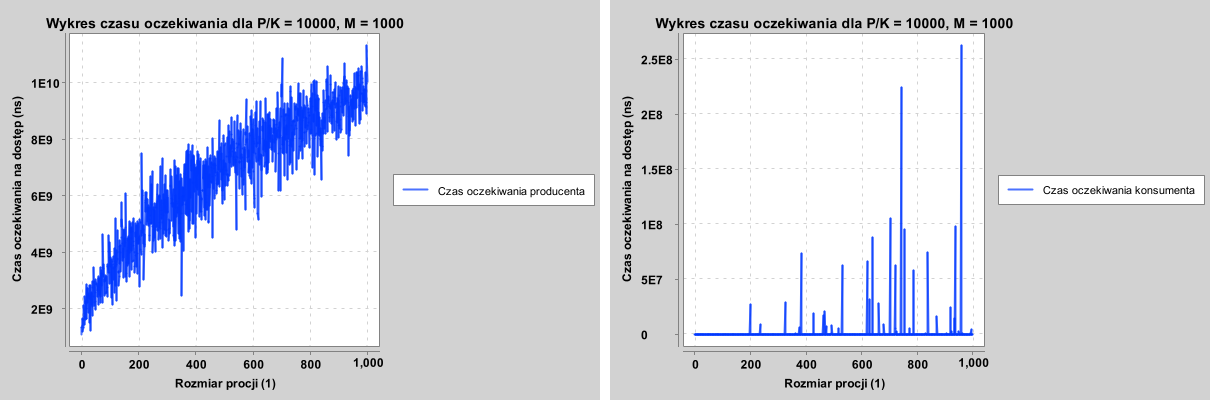

In [103]:
Compute2(10000, 1000, 1);

#### Wykresy zależności

Dla M == 10000

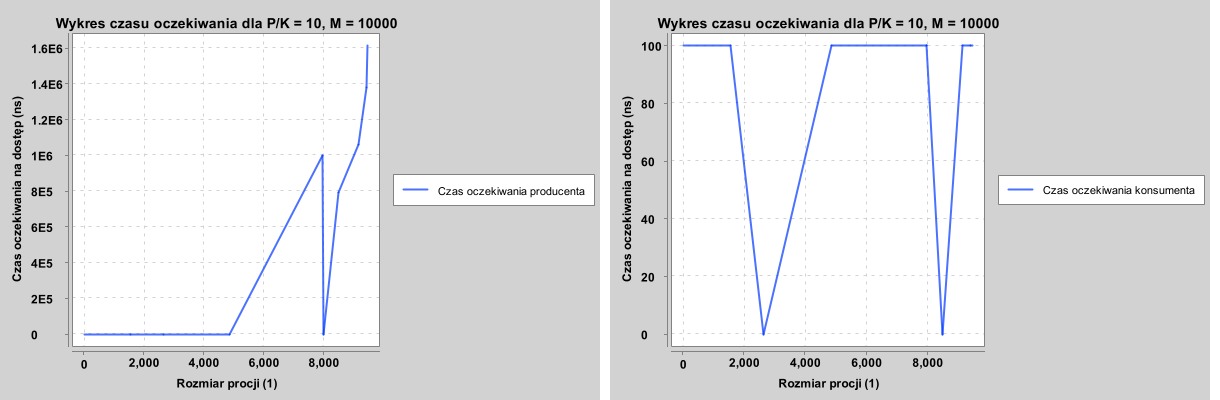

In [104]:
Compute2(10, 10000, 1);

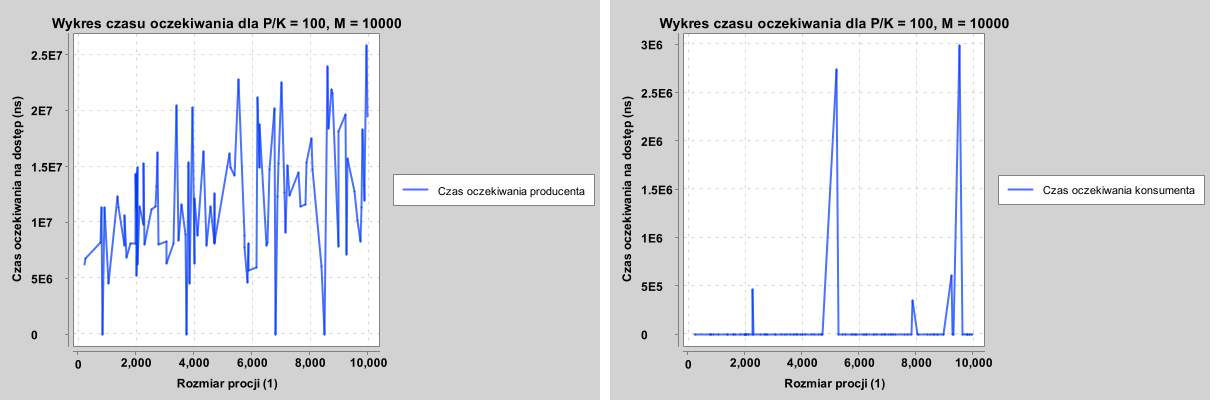

In [105]:
Compute2(100, 10000, 1);

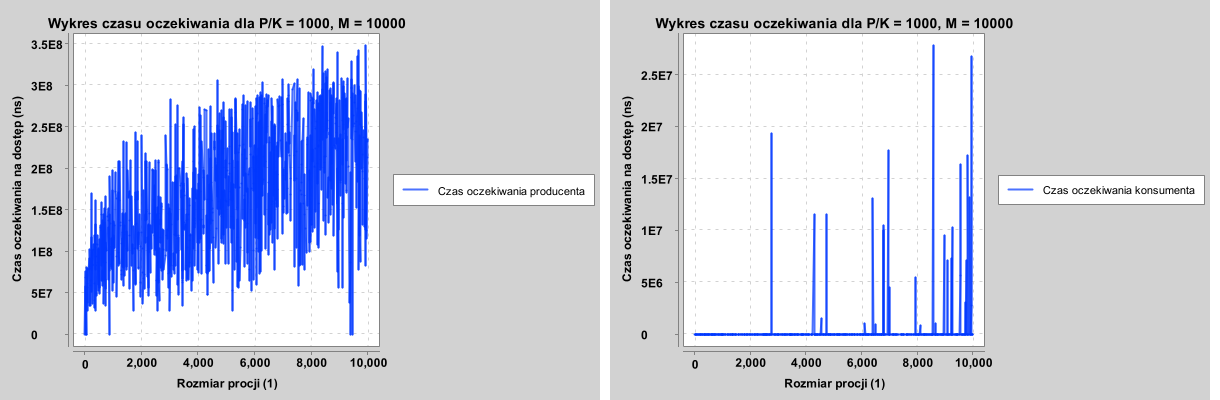

In [107]:
Compute2(1000, 10000, 1);

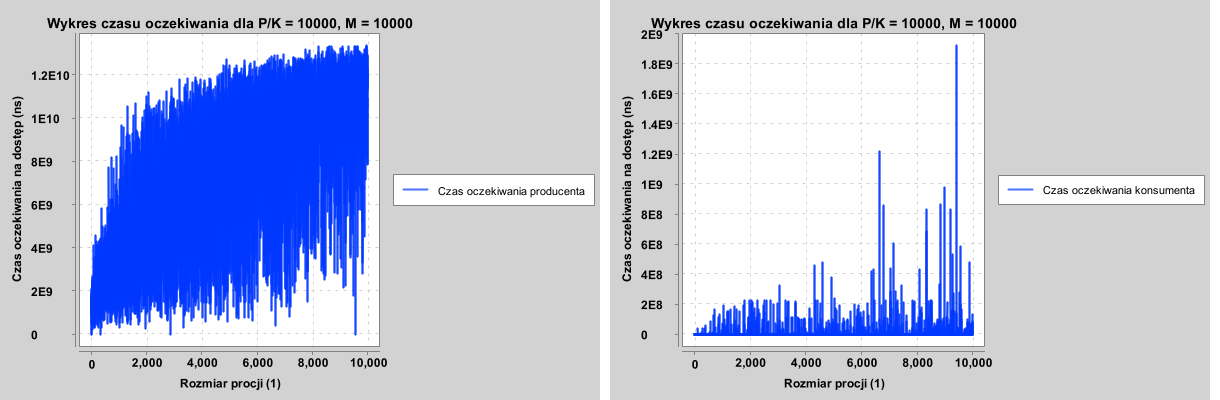

In [108]:
Compute2(10000, 10000, 1);

#### Wykresy zależności
Dla m = 100 000

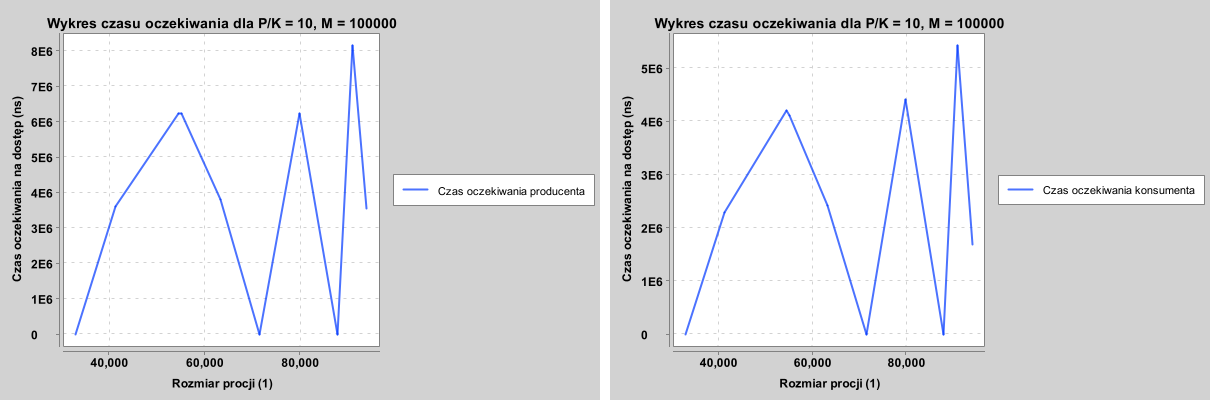

In [109]:
Compute2(10, 100000, 1);

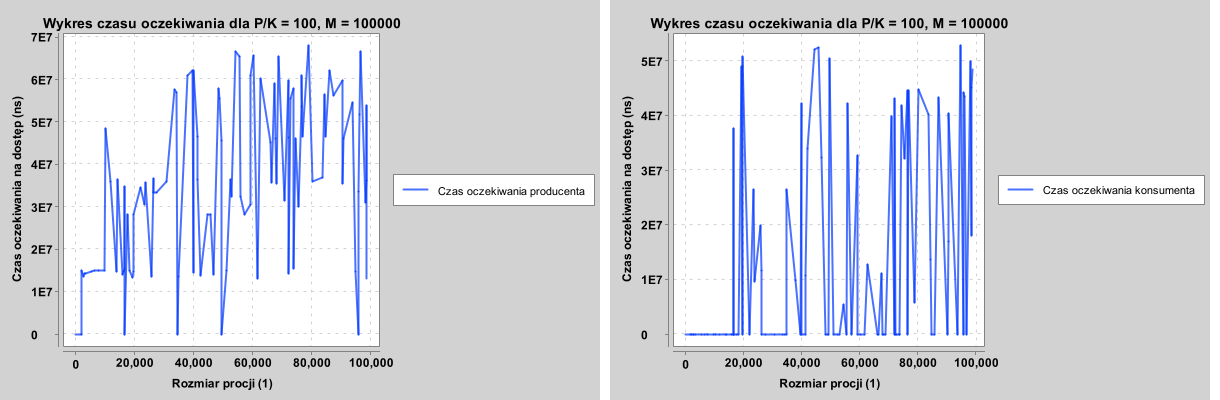

In [110]:
Compute2(100, 100000, 1);

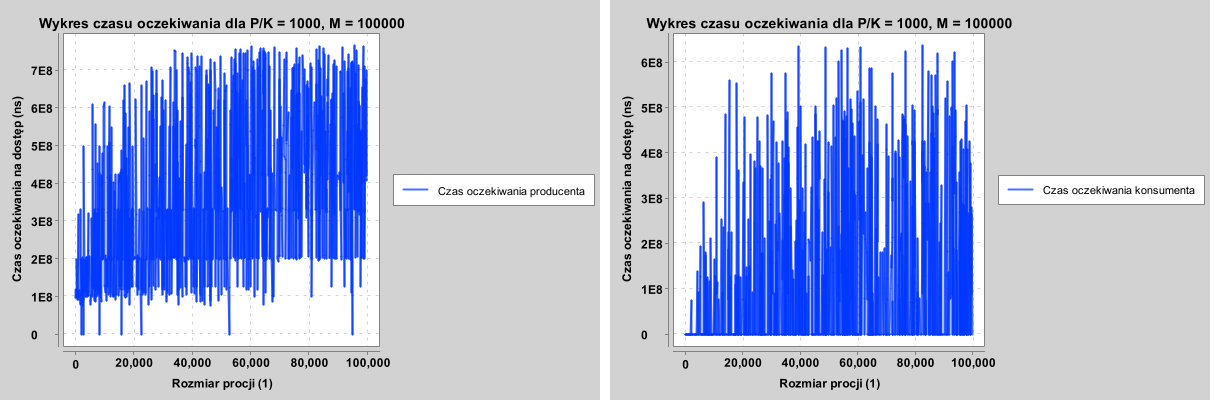

In [114]:
Compute2(1000, 100000, 1);

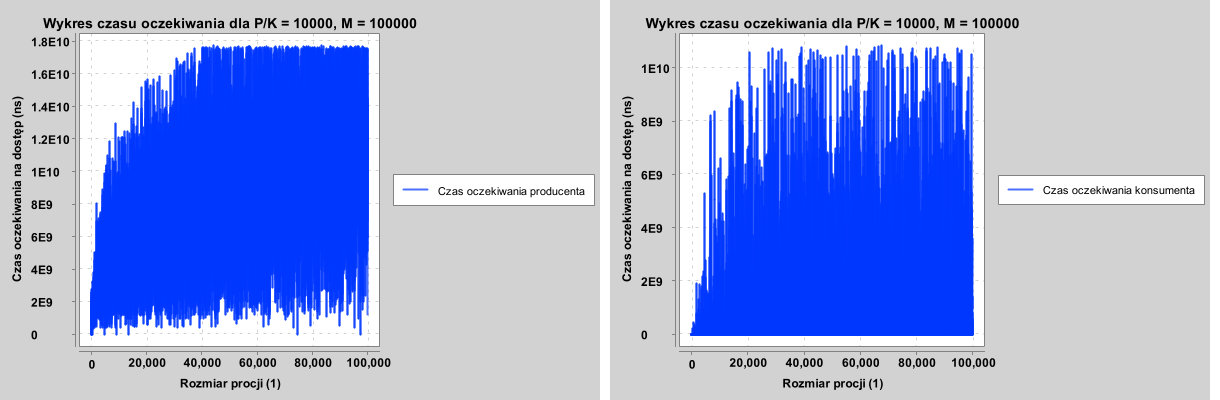

In [115]:
Compute2(10000, 100000, 1);

## Wnioski

Przetwarzanie potokowe zapewnia nam brak przeplatania się wątków i kosztownej synchronizacji danych.
Możemy zobaczyć na wykresach, że czasy wykonania zależą liniowo od konwerterów, a te, jako że są sprężone z poprzednikiem, dostają od razu powiadomienie, że nowa informacja jest gotowa i ją konsumują 

Widzimy wiec, ze wszystkie te 4 byty (Producent, konwerter, konwerter, konsument) mogą w jednym momencie przetwarzać swoją porcję danych (z dokładnością do czasu propagacji danych w potoku, na które wpływa opóźnienie kolejnego konwertera.
Jako, że dane miały być zmieniane w miejscu kolejne konwertery przesuwają kursory na buforze, gdy znajdą się na końcu zaczynają przetwarzać dane od początku (do momentu, gdy cała tablica zostanie zapełniona przez producentów).

W drugim podejściu musimy aktywnie czekać na informacje lub wolne miejce, co prowadzi do wybudzania dodatkowych producentów/konsumentow przez mechanizm suspicious wakeup, więc czasem po sprawdzeniu, czy dany wątek może wykonać akcję idzie znowu spać, przez co czasy oczekiwania są bardzo niestałe.

Jako podsumowanie możemy pokusić się o stwierdzenie, że powinniśmy stosować przetwarzanie potokowe w każdym miejscu, gdzie tylko możemy je zastosować ze względu na rodzaj danych i sposób przetwarzania, ponieważ jest to wydajne rozwiązanie.


# Bibliografia 

1. https://www.benchresources.net/how-to-sort-hashset-in-java-2-ways/
2. https://docs.oracle.com/javase/7/docs/api/java/util/concurrent/locks/Condition.html
3. https://askldjd.com/2010/01/14/pipeline-concurrency-pattern/
4. https://pl.wikipedia.org/wiki/Przetwarzanie_potokowe
5. http://www.jonathanbeard.io/blog/2015/09/19/streaming-and-dataflow.html